<a href="https://colab.research.google.com/github/Yengner/FloorPlan-Project/blob/main/FloorPlan_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [ ]:

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/MyColabNotebook/FLOORPLAN_DATA/train_nw/_annotations.coco.json", "/content/drive/MyDrive/MyColabNotebook/FLOORPLAN_DATA/train_nw")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/MyColabNotebook/FLOORPLAN_DATA/valid_nw/_annotations.coco.json", "/content/drive/MyDrive/MyColabNotebook/FLOORPLAN_DATA/valid_nw")

If data set needs to be changed

In [ ]:
"""
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Unregister existing datasets if already registered
if "my_dataset_train" in DatasetCatalog.list():
    DatasetCatalog.remove("my_dataset_train")
    MetadataCatalog.remove("my_dataset_train")
    print("Unregistered 'my_dataset_train'")

if "my_dataset_val" in DatasetCatalog.list():
    DatasetCatalog.remove("my_dataset_val")
    MetadataCatalog.remove("my_dataset_val")
    print("Unregistered 'my_dataset_val'")

# Register datasets with new data
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/MyColabNotebook/FLOORPLAN_DATA/train_walls/_annotations.coco.json", "/content/drive/MyDrive/MyColabNotebook/FLOORPLAN_DATA/train_walls")
print("Registered new data for 'my_dataset_train'")

register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/MyColabNotebook/FLOORPLAN_DATA/valid_walls/_annotations.coco.json", "/content/drive/MyColabNotebook/FLOORPLAN_DATA/valid_walls")
print("Registered new data for 'my_dataset_val'")



In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

In [ ]:
print(outputs)

{'instances': Instances(num_instances=53, image_height=1280, image_width=1280, fields=[pred_boxes: Boxes(tensor([[ 738.0297,  708.2454,  798.5731,  788.9413],
        [ 671.9053,  616.0607,  730.8229,  695.2109],
        [ 243.7853,  321.6433,  301.3615,  393.5546],
        [ 681.0576,  481.1806,  729.8193,  539.1644],
        [ 496.5696,  671.8000,  543.1124,  725.7939],
        [1075.5142,  481.1108, 1120.6727,  536.5822],
        [ 815.5002,  574.3315,  860.3662,  631.6201],
        [ 454.0603,  317.3907,  471.9743,  378.1761],
        [ 797.9760,  479.9500,  816.4974,  540.9660],
        [1119.6660,  811.0636, 1137.8217,  881.9062],
        [ 465.5023,  318.1546,  798.5048,  337.0269],
        [ 797.5117,  317.7149,  848.0224,  337.3183],
        [ 849.5275,  318.8627, 1128.1144,  337.0454],
        [1023.4258,  338.0993, 1038.7502,  405.1256],
        [1119.9911,  317.5280, 1137.8041,  377.3196],
        [ 815.2957,  522.2417,  855.0042,  539.4404],
        [ 730.0056,  810.2836, 

In [ ]:
from matplotlib import pyplot as plt

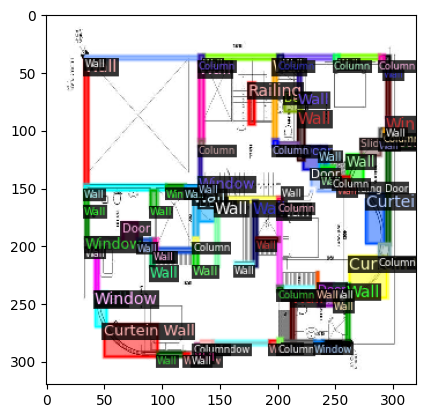

In [ ]:
for d in random.sample(train_dataset_dicts, 1):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
  vis = visualizer.draw_dataset_dict(d)
  plt.imshow(vis.get_image()[:, :, ::-1])
  plt.show()

In [ ]:
"""
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/MyColabNotebook/models/Floorplan_detection_Test"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2   # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 1e-3  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
"""

In [ ]:
# Calculation based on a batch size of 2
num_epochs = 200  # Middle ground in the range
num_training_images = 174
batch_size = 2
max_iter = (num_training_images / batch_size) * num_epochs

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.modeling import build_model
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/MyColabNotebook/models/init_floorplan_detection_walls"
cfg.merge_from_file("/content/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Use pre-trained weights as a starting point
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = int(max_iter)  # Calculated above
cfg.SOLVER.STEPS = (int(max_iter * 0.6), int(max_iter * 0.8))  # Reduce learning rate at 60% and 80% of training
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Create a MyTrainer object
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)

In [ ]:
trainer.train()

[04/14 21:46:18 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/14 21:46:30 d2.utils.events]:  eta: 1:41:20  iter: 19  total_loss: 7.443  loss_cls: 2.314  loss_box_reg: 0.3111  loss_mask: 0.691  loss_rpn_cls: 3.069  loss_rpn_loc: 1.059    time: 0.3483  last_time: 0.2945  data_time: 0.0361  last_data_time: 0.0096   lr: 4.9952e-05  max_mem: 1770M
[04/14 21:46:39 d2.utils.events]:  eta: 1:40:30  iter: 39  total_loss: 3.722  loss_cls: 1.4  loss_box_reg: 0.3241  loss_mask: 0.6525  loss_rpn_cls: 0.3477  loss_rpn_loc: 0.9615    time: 0.3462  last_time: 0.3409  data_time: 0.0109  last_data_time: 0.0200   lr: 9.9902e-05  max_mem: 1906M
[04/14 21:46:46 d2.utils.events]:  eta: 1:40:13  iter: 59  total_loss: 3.097  loss_cls: 0.9839  loss_box_reg: 0.4654  loss_mask: 0.5711  loss_rpn_cls: 0.2879  loss_rpn_loc: 0.771    time: 0.3482  last_time: 0.3193  data_time: 0.0243  last_data_time: 0.0070   lr: 0.00014985  max_mem: 1906M
[04/14 21:46:53 d2.utils.events]:  eta: 1:38:22  iter: 79  total_loss: 2.759  loss_cls: 0.8475  loss_box_reg: 0.4563  loss_mask: 0.4774

NameError: name 'COCOEvaluator' is not defined

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


[04/14 23:34:41 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [04/14 23:34:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/14 23:34:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/14 23:34:41 d2.data.datasets.coco]: Loaded 165 images in COCO format from /content/drive/MyDrive/MyColabNotebook/FLOORPLAN_DATA/valid_nw/_annotations.coco.json
[04/14 23:34:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/14 23:34:41 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/14 23:34:41 d2.data.common]: Serializing 165 elements to byte tensors and concatenating them all ...
[04/14 23:34:

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/14 23:34:43 d2.evaluation.evaluator]: Inference done 11/165. Dataloading: 0.0016 s/iter. Inference: 0.0962 s/iter. Eval: 0.0596 s/iter. Total: 0.1574 s/iter. ETA=0:00:24
[04/14 23:34:48 d2.evaluation.evaluator]: Inference done 40/165. Dataloading: 0.0055 s/iter. Inference: 0.0997 s/iter. Eval: 0.0663 s/iter. Total: 0.1716 s/iter. ETA=0:00:21
[04/14 23:34:53 d2.evaluation.evaluator]: Inference done 70/165. Dataloading: 0.0041 s/iter. Inference: 0.0989 s/iter. Eval: 0.0664 s/iter. Total: 0.1696 s/iter. ETA=0:00:16
[04/14 23:34:58 d2.evaluation.evaluator]: Inference done 104/165. Dataloading: 0.0034 s/iter. Inference: 0.0976 s/iter. Eval: 0.0616 s/iter. Total: 0.1626 s/iter. ETA=0:00:09
[04/14 23:35:03 d2.evaluation.evaluator]: Inference done 133/165. Dataloading: 0.0037 s/iter. Inference: 0.0984 s/iter. Eval: 0.0631 s/iter. Total: 0.1653 s/iter. ETA=0:00:05
[04/14 23:35:08 d2.evaluation.evaluator]: Total inference time: 0:00:25.927132 (0.162045 s / iter per device, on 1 devices)
[04/

In [ ]:
%load_ext tensorboard

%tensorboard --logdir /content/drive/MyDrive/MyColabNotebook/models/init_Floorplan_detection_walls/ --port 6007

In [ ]:
import yaml
config_yaml_path = "/content/drive/MyDrive/MyColabNotebook/models/init_floorplan_detection_walls/init_config.yaml"
with open(config_yaml_path, 'w') as file:

  yaml.dump(cfg, file)


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
predictor = DefaultPredictor(cfg)

[04/14 23:34:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/MyColabNotebook/models/init_floorplan_detection_walls/model_final.pth ...


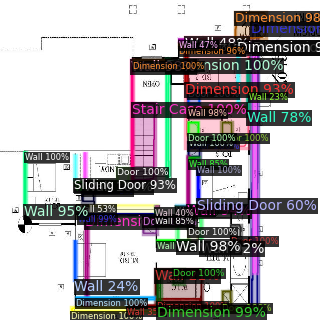

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(train_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:
import numpy as np
import torch
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

# Initialize the Detectron2 model
cfg = get_cfg()
# Add the configuration for your model here
cfg.merge_from_file("/content/drive/MyDrive/MyColabNotebook/models/init_floorplan_detection_walls/init_config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/MyColabNotebook/models/init_floorplan_detection_walls/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # Set the detection threshold

predictor = DefaultPredictor(cfg)

# Load the image
image = cv2.imread("/content/drive/MyDrive/MyColabNotebook/FLOORPLAN_DATA/Plan_006_jpg.rf.6978f4b589606036edacb5e75d171935.jpg")

# Run inference
outputs = predictor(image)

# Filter the detections by the wall class (class ID 8)
wall_masks = outputs["instances"].pred_masks[outputs["instances"].pred_classes == 8]

# Define your scale (pixels to feet)
PIXEL_TO_FEET_SCALE = 1 / 50  # Adjust this to your scale

# Assuming the wall height is uniform and known
wall_height_feet = 9  # For example, 9 feet

# Calculate the area covered by wall masks in pixels
wall_area_pixels = wall_masks.sum().item()

# Convert pixels to square feet (assuming square pixels)
wall_area_feet = wall_area_pixels * (PIXEL_TO_FEET_SCALE ** 2)

# If the masks represent the wall length, multiply by the height of the walls to get square footage
total_wall_area_feet = wall_area_feet * wall_height_feet

# Print the total square footage of the walls
print(f"Total square footage of walls: {total_wall_area_feet} sq ft")


[04/15 03:01:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/MyColabNotebook/models/init_floorplan_detection_walls/model_final.pth ...
Total square footage of walls: 365.4612 sq ft
